In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



In [2]:
np.random.seed(42)

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

print("\nFirst few rows of training data:")
print(train_df.head())
print("\nDataset information:")
print(train_df.info())


Training set shape: (891, 12)
Testing set shape: (418, 11)

First few rows of training data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0       

In [3]:
def preprocess_data(df, is_training=True):
    df_processed = df.copy()
    
    df_processed['Age'] = df_processed['Age'].fillna(df_processed['Age'].median())
    df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])
    df_processed['Fare'] = df_processed['Fare'].fillna(df_processed['Fare'].median())
    
    df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1
    df_processed['IsAlone'] = (df_processed['FamilySize'] == 1).astype(int)
    
    df_processed['Sex'] = df_processed['Sex'].map({'male': 0, 'female': 1})
    df_processed['Embarked'] = df_processed['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
    
    features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']
    X = df_processed[features]
    
    if is_training:
        y = df_processed['Survived']
        return X, y
    return X



Processed training set shape: (712, 7)
Processed validation set shape: (179, 7)
Processed test set shape: (418, 7)


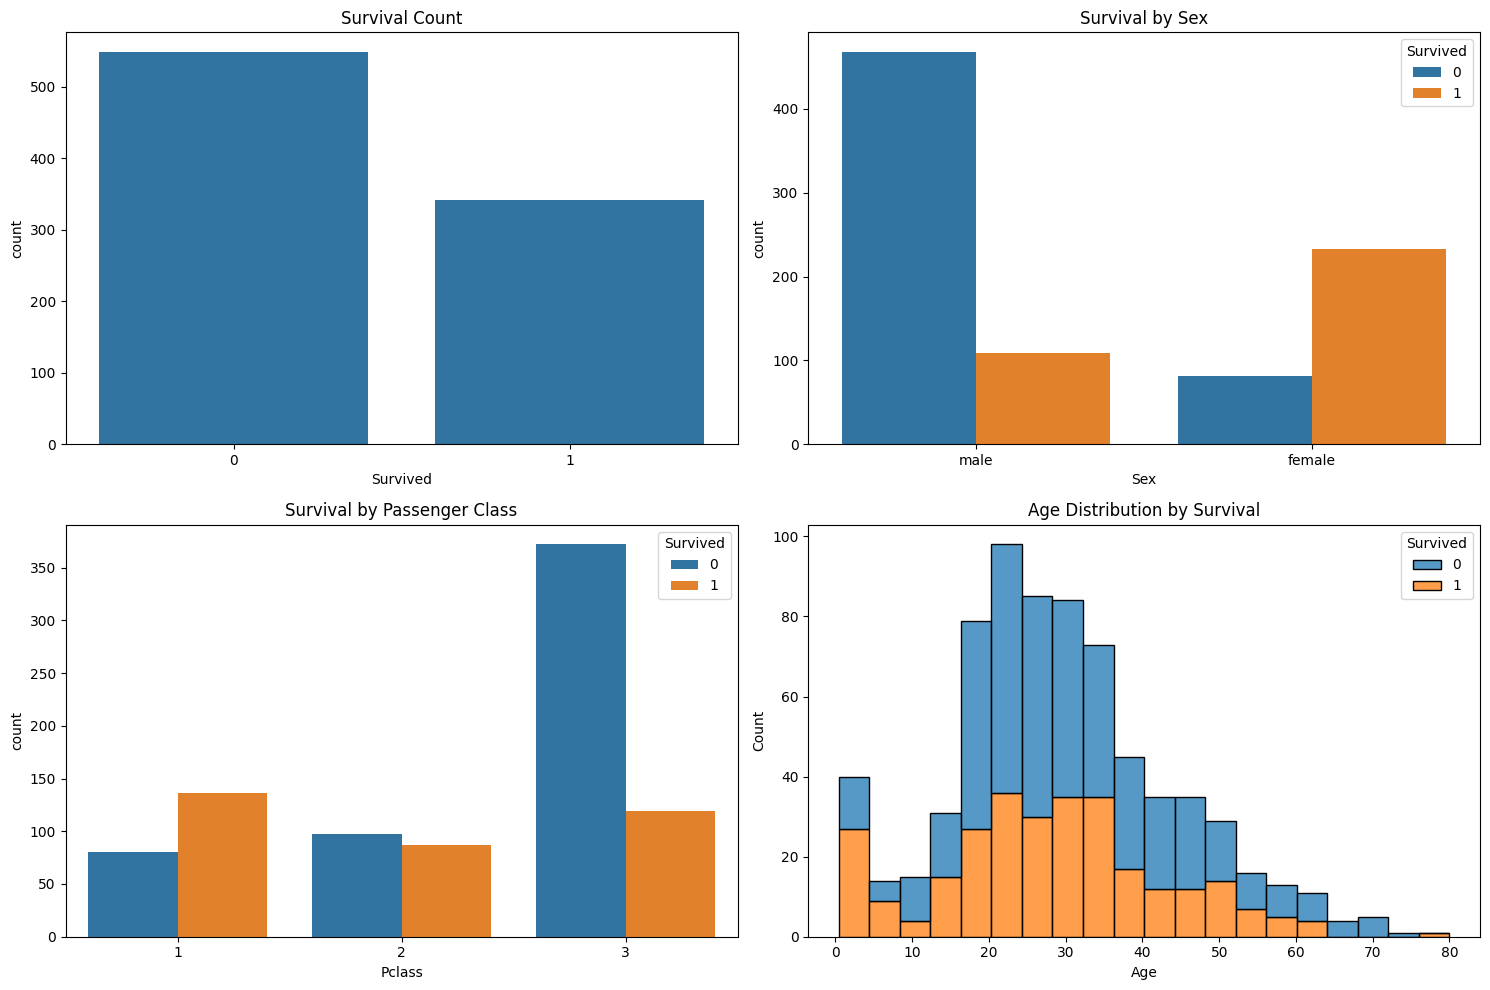

In [4]:
X_train, y_train = preprocess_data(train_df, is_training=True)
X_test = preprocess_data(test_df, is_training=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nProcessed training set shape:", X_train_scaled.shape)
print("Processed validation set shape:", X_val_scaled.shape)
print("Processed test set shape:", X_test_scaled.shape)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.countplot(data=train_df, x='Survived')
plt.title('Survival Count')

plt.subplot(2, 2, 2)
sns.countplot(data=train_df, x='Sex', hue='Survived')
plt.title('Survival by Sex')

plt.subplot(2, 2, 3)
sns.countplot(data=train_df, x='Pclass', hue='Survived')
plt.title('Survival by Passenger Class')

plt.subplot(2, 2, 4)
sns.histplot(data=train_df, x='Age', hue='Survived', multiple="stack")
plt.title('Age Distribution by Survival')

plt.tight_layout()
plt.show()


In [5]:
class NaiveBayes:
    def __init__(self):
        self.class_priors = None
        self.class_means = None
        self.class_variances = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        self.class_priors = np.zeros(n_classes)
        self.class_means = np.zeros((n_classes, n_features))
        self.class_variances = np.zeros((n_classes, n_features))
        
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.class_priors[i] = X_c.shape[0] / n_samples
            self.class_means[i] = X_c.mean(axis=0)
            self.class_variances[i] = X_c.var(axis=0)
    
    def _calculate_likelihood(self, x, mean, var):
        var = var + 1e-9
        return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-((x - mean) ** 2) / (2 * var))
    
    def predict(self, X):
        y_pred = []
        
        for x in X:
            posteriors = []
            
            for i, c in enumerate(self.classes):
                prior = np.log(self.class_priors[i])
                likelihood = np.sum(np.log(self._calculate_likelihood(x, self.class_means[i], self.class_variances[i])))
                posterior = prior + likelihood
                posteriors.append(posterior)
            
            y_pred.append(self.classes[np.argmax(posteriors)])
            
        return np.array(y_pred)


In [6]:
nb_model = NaiveBayes()
nb_model.fit(X_train_scaled, y_train)
nb_predictions = nb_model.predict(X_val_scaled)
nb_accuracy = np.mean(nb_predictions == y_val)
print(f"Naive Bayes Validation Accuracy: {nb_accuracy:.4f}")


Naive Bayes Validation Accuracy: 0.7821


In [13]:
class KNN:
    def __init__(self, k=3):
        self.k = k
        
    def fit(self, X, y):
        # Convert to numpy arrays to ensure consistent indexing
        self.X_train = np.array(X)
        self.y_train = np.array(y, dtype=int)
        
    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def predict(self, X):
        # Convert input to numpy array
        X = np.array(X)
        y_pred = []
        
        for x in X:
            # Calculate distances to all training points
            distances = np.array([self._euclidean_distance(x, x_train) for x_train in self.X_train])
            
            # Get indices of k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
            
            # Get labels of k nearest neighbors using numpy array indexing
            k_nearest_labels = self.y_train[k_indices]
            
            # Count occurrences of each label
            unique_labels, counts = np.unique(k_nearest_labels, return_counts=True)
            # Get the label with maximum count
            most_common = unique_labels[np.argmax(counts)]
            
            y_pred.append(int(most_common))
            
        return np.array(y_pred, dtype=int)

KNN Validation Accuracy (k=1): 0.7821
KNN Validation Accuracy (k=3): 0.8045
KNN Validation Accuracy (k=5): 0.7989
KNN Validation Accuracy (k=7): 0.7989
KNN Validation Accuracy (k=9): 0.8045


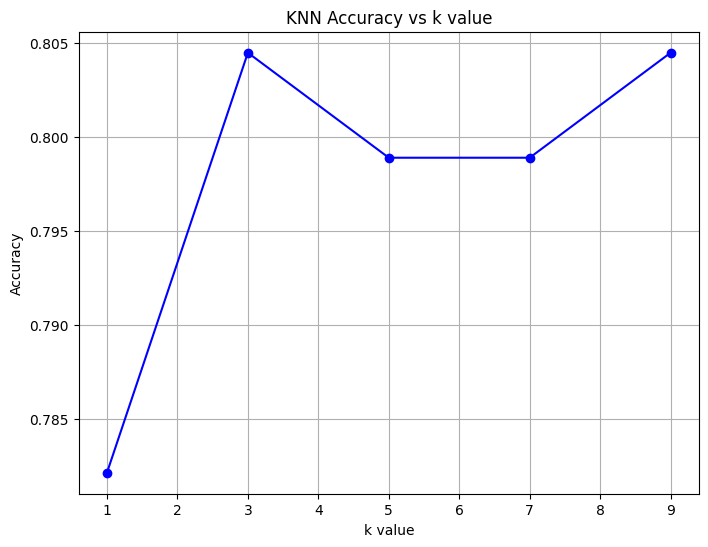

In [18]:
X_train_scaled = np.array(X_train_scaled)
X_val_scaled = np.array(X_val_scaled)
y_train = np.array(y_train, dtype=int)
y_val = np.array(y_val, dtype=int)

k_values = [1, 3, 5, 7, 9]
knn_accuracies = []

for k in k_values:
    try:
        knn_model = KNN(k=k)
        knn_model.fit(X_train_scaled, y_train)
        knn_predictions = knn_model.predict(X_val_scaled)
        accuracy = np.mean(knn_predictions == y_val)
        knn_accuracies.append(accuracy)
        print(f"KNN Validation Accuracy (k={k}): {accuracy:.4f}")
    except Exception as e:
        print(f"Error occurred for k={k}: {str(e)}")
        knn_accuracies.append(None)

successful_k = [k for k, acc in zip(k_values, knn_accuracies) if acc is not None]
successful_accuracies = [acc for acc in knn_accuracies if acc is not None]

if successful_k:
    plt.figure(figsize=(8, 6))
    plt.plot(successful_k, successful_accuracies, 'bo-')
    plt.xlabel('k value')
    plt.ylabel('Accuracy')
    plt.title('KNN Accuracy vs k value')
    plt.grid(True)
    plt.show()
else:
    print("No successful KNN predictions were made. Please check the data format and preprocessing steps.")

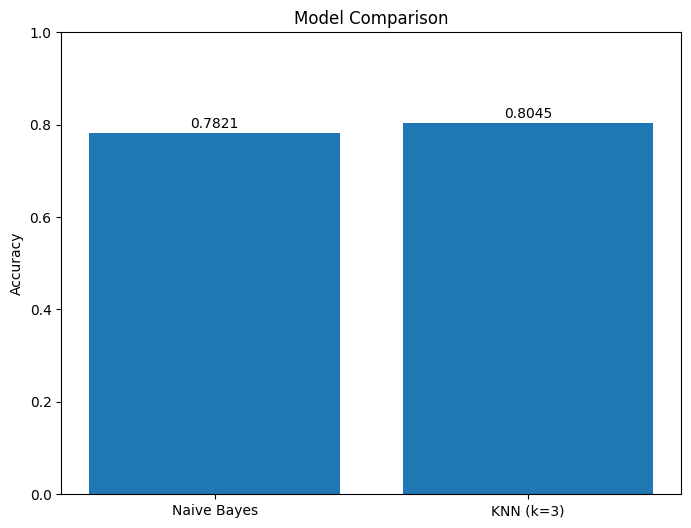

In [15]:
models = ['Naive Bayes', 'KNN (k=3)']
accuracies = [nb_accuracy, knn_accuracies[1]]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Comparison')

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.show()


In [17]:
best_k = k_values[np.argmax(knn_accuracies)]
print(f"\nUsing KNN with k={best_k} for final predictions")

final_model = KNN(k=best_k)
final_model.fit(X_train_scaled, y_train)
test_predictions = final_model.predict(X_test_scaled)

submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("\nPredictions saved to submission.csv")


Using KNN with k=3 for final predictions

Predictions saved to submission.csv
